In [ ]:
import torch
from tqdm import tqdm
import pickle
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertModel, BertConfig, PreTrainedTokenizer, BasicTokenizer, BertForTokenClassification
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoConfig, AutoModelForSequenceClassification
import collections
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t')
model = AutoModel.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_csv('/content/endo_fasta.csv')

In [ ]:
chunk_size = 10000
num_chunks = len(df) // chunk_size + int(len(df) % chunk_size != 0)

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))
    chunk = df['raw_sequence'][start_idx:end_idx]

    embeddings = []

    for seq in chunk:
        inputs = tokenizer(seq, return_tensors='pt')["input_ids"]
        hidden_states = model(inputs)[0]
        embedding_mean = torch.mean(hidden_states[0], dim=0)
        embeddings.append(embedding_mean.detach().numpy())

    np.save(f'embeddings_chunk_{i}.npy', np.array(embeddings))
    print(f"Processed and saved chunk {i + 1}/{num_chunks}")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Processed and saved chunk 1/40
Processed and saved chunk 2/40
Processed and saved chunk 3/40
Processed and saved chunk 4/40
Processed and saved chunk 5/40
Processed and saved chunk 6/40
Processed and saved chunk 7/40
Processed and saved chunk 8/40
Processed and saved chunk 9/40
Processed and saved chunk 10/40
Processed and saved chunk 11/40
Processed and saved chunk 12/40
Processed and saved chunk 13/40
Processed and saved chunk 14/40
Processed and saved chunk 15/40
Processed and saved chunk 16/40
Processed and saved chunk 17/40
Processed and saved chunk 18/40
Processed and saved chunk 19/40
Processed and saved chunk 20/40
Processed and saved chunk 21/40
Processed and saved chunk 22/40
Processed and saved chunk 23/40
Processed and saved chunk 24/40
Processed and saved chunk 25/40
Processed and saved chunk 26/40
Processed and saved chunk 27/40
Processed and saved chunk 28/40
Processed and saved chunk 29/40
Processed and saved chunk 30/40


KeyboardInterrupt: 

In [ ]:
device = "cuda"

In [ ]:
# files = ["k=6.pickle", "k=5.pickle", "k=4.pickle", "k=3.pickle"]

In [ ]:
lst = []
for fe in files:
  with open(fe, "rb") as input_file:
      e = pickle.load(input_file)
      lst.append(e)

In [ ]:
all_embeddings = []
for i in range(5):
    # chunk_embeddings = np.load(f'/content/drive/My Drive/dnabert2_emb/embeddings_chunk_{i}.npy')
    chunk_embeddings = np.load(f'embeddings_chunk_{i}.npy')
    all_embeddings.append(chunk_embeddings)

all_embeddings = np.concatenate(all_embeddings, axis=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from itertools import chain

In [ ]:
seqes = list(chain(*lst))

In [ ]:
def label_encode(sequences, max_length=None):
    encoder = LabelEncoder()
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    # Pad sequences to the maximum length
    padded_sequences = [seq.ljust(max_length, '-') for seq in sequences]

    encoded_sequences = np.array([list(seq) for seq in padded_sequences])
    for i in range(encoded_sequences.shape[1]):
        encoded_sequences[:, i] = encoder.fit_transform(encoded_sequences[:, i])
    return encoded_sequences.astype(int)

encoded_sequences = label_encode(seqes)
print(encoded_sequences)

[[1 1 2 2 2 2]
 [1 1 1 3 2 2]
 [1 1 1 2 3 2]
 ...
 [2 4 0 0 0 0]
 [0 4 0 0 0 0]
 [4 0 4 0 0 0]]


In [ ]:
encoded_sequences = all_embeddings[:30000]

jaccard_sim_matrix = pairwise_distances(encoded_sequences, metric='jaccard')

clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average')
labels = clustering.fit_predict(jaccard_sim_matrix)

# clusters = {i: [] for i in range(4)}
# for seq, label in zip(all_embeddings[:10000] , labels):
#     clusters[label].append(seq)

# for cluster, seqs in clusters.items():
#     print(f"Cluster {cluster}: {seqs}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


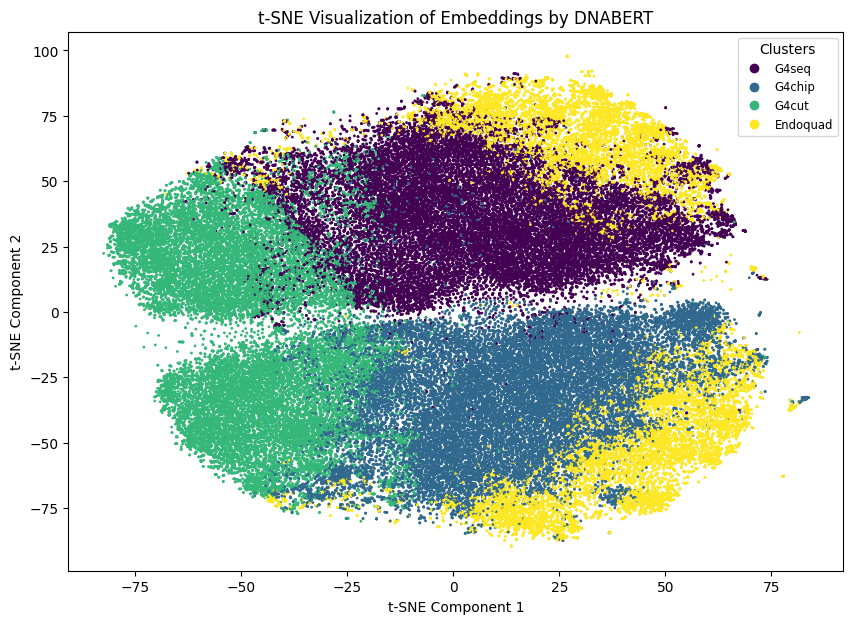

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 7))
# # cluster_colors = ['purple', 'blue', 'green', 'yellow']
# color_map = mcolors.ListedColormap(cluster_colors)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=1, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings by DNABERT')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

handles, _ = scatter.legend_elements()
# cluster_names = [f'Cluster {i}' for i in range(num_clusters)]
cluster_names = ['G4seq', 'G4chip', 'G4cut', 'Endoquad']
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')

plt.show()


In [ ]:
all_embeddings.shape

(100000, 32000)

In [ ]:
class SequencesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoded_sequence = self.sequences[idx]

        return torch.tensor(encoded_sequence, dtype=torch.float32)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=100, input_dim=32000):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, latent_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size=100, output_dim=32000):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=100, input_dim=32000, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.input_dim = input_dim
        self.E = Encoder(latent_size, input_dim)
        self.D = Decoder(latent_size, input_dim)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out

    def rho_loss(self, rho, size_average=True):
        dkl = - rho * torch.log(self.data_rho) - (1-rho) * torch.log(1 - self.data_rho)  # calculates KL divergence
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss


In [ ]:
models = {"16": Net(16), "64": Net(64), "256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
encoded_sequences = all_embeddings

In [ ]:
if isinstance(encoded_sequences, np.ndarray):
    encoded_sequences = [torch.tensor(seq, dtype=torch.float32) for seq in encoded_sequences]

In [ ]:
encoded_sequences[0].shape

torch.Size([32000])

In [ ]:
train_set, test_set = train_test_split(encoded_sequences, test_size=0.2, random_state=42)


train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)


train_dataset = SequencesDataset(train_set)
val_dataset = SequencesDataset(val_set)
test_dataset = SequencesDataset(test_set)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

In [ ]:
dataset = SequencesDataset(encoded_sequences)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

models = {"256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}


train_set, test_set = train_test_split(encoded_sequences, test_size=0.2, random_state=42)

train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

train_dataset = SequencesDataset(train_set)
val_dataset = SequencesDataset(val_set)
test_dataset = SequencesDataset(test_set)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

models = {"256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
val_log = {k: [] for k in models}
test_log = {k: [] for k in models}

def train(epoch, models, log=None, optimizer_params=None, add_noise=False, half_image=False):
    train_size = len(train_loader.dataset)

    for model in models.values():
        model.optim = optim.Adam(model.parameters(), **optimizer_params)

    for batch_idx, data in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            output = model(inputs)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

def evaluate(loader, models, log):
    size = len(loader.dataset)
    for model_key, model in models.items():
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in loader:
                inputs = data.clone().detach()
                output = model(inputs)
                test_loss += model.loss(output, data).item()
        test_loss /= size
        print(f"{model_key} Test set: Average loss: {test_loss:.4f}")
        log[model_key].append(test_loss)

optimizer_params = {"lr": 1e-5, "weight_decay": 0.09}
for epoch in range(1, 10):
    train(epoch, models, train_log, optimizer_params=optimizer_params)
    evaluate(val_loader, models, val_log)


In [ ]:
for epoch in range(1, 10):
    for batch_idx, data in enumerate(dataloader):
        output = models["256"](data)
        to_plot = output.data.numpy()

        decoder_weights = models["256"].D.fc1.weight
        decoded = torch.matmul(torch.eye(256), decoder_weights.T)
        dec_to_plot = decoded.data.numpy()

        with torch.no_grad():
            encoded = models["256"].E(data)

            # print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))

            encoded[encoded < 0.5] = 0.

            decoded_f = torch.matmul(encoded, decoder_weights.T)
            f_to_plot = decoded_f.data.numpy()

<ipython-input-7-b03ce35c102b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(encoded_sequence, dtype=torch.float32)


In [ ]:
output = models["256"](data)
to_plot = output.data.numpy()

decoder_weights = models["256"].D.fc1.weight
decoded = torch.matmul(torch.eye(256), decoder_weights.T)
dec_to_plot = decoded.data.numpy()


with torch.no_grad():
    encoded = models["256"].E(data)

    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))

    encoded[encoded < 0.5] = 0.

    decoded_f = torch.matmul(encoded, decoder_weights.T)
    f_to_plot = decoded_f.data.numpy()

In [ ]:
def noise_seq(x, noise_level=0.5):
    f = x + noise_level * torch.randn_like(x)
    return f

def noise_batch(batch, noise_level=0.5):
    batch_z = batch.clone().detach()
    for i in range(batch_z.shape[0]):
        batch_z[i] = noise_seq(batch_z[i], noise_level=noise_level)
    return batch_z

In [ ]:
models = {"256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
def train(epoch, models, log=None, optimizer_params=None, add_noise=True, noise_level=0.1):
    train_size = len(train_loader.dataset)

    for model in models.values():
        model.optim = optim.Adam(model.parameters(), **optimizer_params)

    for batch_idx, data in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()

            if add_noise:
                inputs = noise_batch(inputs, noise_level=noise_level)

            output = model(inputs)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

optimizer_params = {"lr": 1e-5, "weight_decay": 0.09}
for epoch in range(1, 10):
    train(epoch, models, train_log, optimizer_params=optimizer_params, add_noise=True, noise_level=0.5)
    evaluate(val_loader, models, val_log)


<ipython-input-5-b03ce35c102b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(encoded_sequence, dtype=torch.float32)


Train Epoch: 1 [0/96000 (0%)]	Losses 256: 39.188728
Train Epoch: 1 [25600/96000 (27%)]	Losses 256: 39.084545
Train Epoch: 1 [51200/96000 (53%)]	Losses 256: 39.296780
Train Epoch: 1 [76800/96000 (80%)]	Losses 256: 39.224773
Train Epoch: 1 [96000/96000 (100%)]	Losses 256: 39.052711
256 Test set: Average loss: 0.3055
Train Epoch: 2 [0/96000 (0%)]	Losses 256: 38.941147
Train Epoch: 2 [25600/96000 (27%)]	Losses 256: 38.814693
Train Epoch: 2 [51200/96000 (53%)]	Losses 256: 39.028267
Train Epoch: 2 [76800/96000 (80%)]	Losses 256: 38.572109
Train Epoch: 2 [96000/96000 (100%)]	Losses 256: 38.780407
256 Test set: Average loss: 0.3041
Train Epoch: 3 [0/96000 (0%)]	Losses 256: 38.862244
Train Epoch: 3 [25600/96000 (27%)]	Losses 256: 39.368500
Train Epoch: 3 [51200/96000 (53%)]	Losses 256: 38.740665
Train Epoch: 3 [76800/96000 (80%)]	Losses 256: 37.558929
Train Epoch: 3 [96000/96000 (100%)]	Losses 256: 38.178360
256 Test set: Average loss: 0.2996
Train Epoch: 4 [0/96000 (0%)]	Losses 256: 38.404652


In [ ]:
full_dataset = np.concatenate((train_set, test_set), axis=0)

full_dataset = SequencesDataset(full_dataset)
full_loader = DataLoader(full_dataset, batch_size=128)

reconstructed_data = []

for model in models.values():
    model.eval()

with torch.no_grad():
    for data in full_loader:
        output = models["256"](data)
        reconstructed_data.append(output.numpy())

reconstructed_data = np.concatenate(reconstructed_data, axis=0)


In [ ]:
reconstructed_data.shape

(42000, 32000)

In [ ]:
jaccard_sim_matrix = pairwise_distances(reconstructed_data[:30000], metric='jaccard')

clustering = SpectralClustering(n_clusters=2, affinity='precomputed')
labels = clustering.fit_predict(1 - jaccard_sim_matrix)

clusters = {i: [] for i in range(2)}
for seq, label in zip(e, labels):
    clusters[label].append(seq)

for cluster, seqs in clusters.items():
    print(f"Cluster {cluster}: {seqs}")

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(reconstructed_data)

# Plotting the clusters
plt.figure(figsize=(10, 7))
for i in range(2):
    cluster_data = reduced_data
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1])

plt.title('Reconstructed PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
files = ["hyena_k=6.pickle", "hyena_k=5.pickle", "hyena_k=4.pickle", "hyena_k=3.pickle", "bert2_k=3.pickle",
         "bert2_k=4.pickle", "bert2_k=5.pickle", "bert2_k=6.pickle", "k=4.pickle", "k=5.pickle",
         "k=3.pickle"]
# files = ["hyena_k=6.pickle", "hyena_k=5.pickle", "hyena_k=4.pickle", "hyena_k=3.pickle", "bert2_k=3.pickle",
#          "bert2_k=4.pickle", "bert2_k=5.pickle", "bert2_k=6.pickle"]

In [ ]:
from itertools import chain

In [ ]:
lst = []
for fe in files:
  with open(fe, "rb") as input_file:
      e = pickle.load(input_file)
      lst.append(e)

In [ ]:
seqes = list(chain(*lst))

In [ ]:
def label_encode(sequences, max_length=None):
    encoder = LabelEncoder()
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    # Pad sequences to the maximum length
    padded_sequences = [seq.ljust(max_length, '-') for seq in sequences]

    encoded_sequences = np.array([list(seq) for seq in padded_sequences])
    for i in range(encoded_sequences.shape[1]):
        encoded_sequences[:, i] = encoder.fit_transform(encoded_sequences[:, i])
    return encoded_sequences.astype(int)

encoded_sequences = label_encode(seqes)
# print(encoded_sequences)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


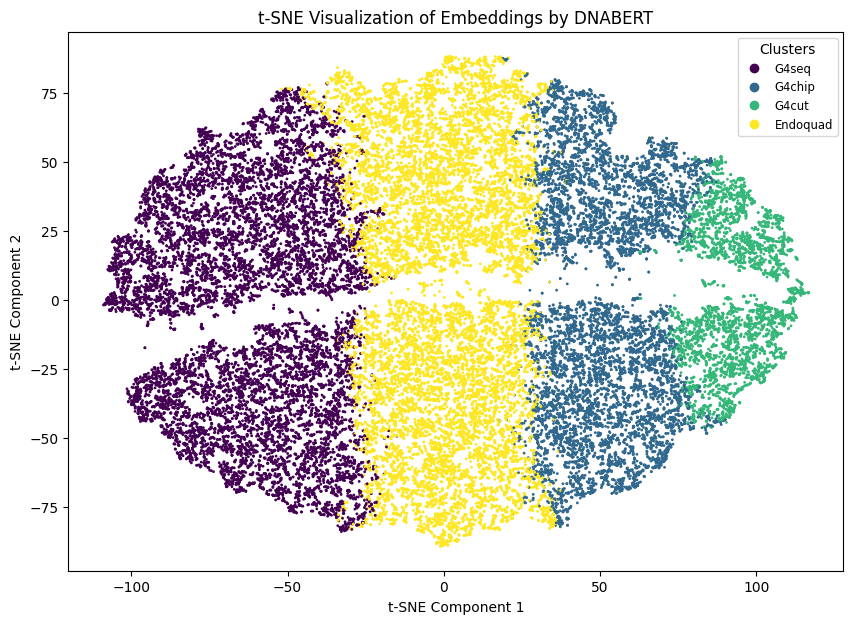

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reconstructed_data)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(reconstructed_data)

plt.figure(figsize=(10, 7))
# # cluster_colors = ['purple', 'blue', 'green', 'yellow']
# color_map = mcolors.ListedColormap(cluster_colors)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=1, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings by DNABERT')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

handles, _ = scatter.legend_elements()
# cluster_names = [f'Cluster {i}' for i in range(num_clusters)]
cluster_names = ['G4seq', 'G4chip', 'G4cut', 'Endoquad']
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')

plt.show()


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(encoded_sequences)

In [ ]:
labels=kmeans.labels_

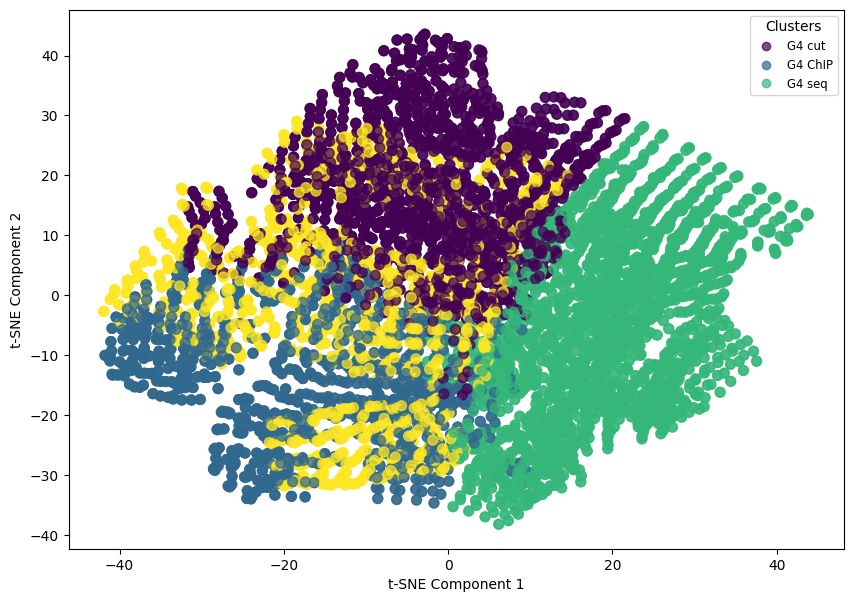

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(encoded_sequences)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, s=50, cmap='viridis', alpha=0.7)
# plt.title('')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
handles, _ = scatter.legend_elements()
cluster_names = ["G4 cut", "G4 ChIP", "G4 seq", "Endoquad"]  # Adjust cluster names as needed
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')
plt.show()

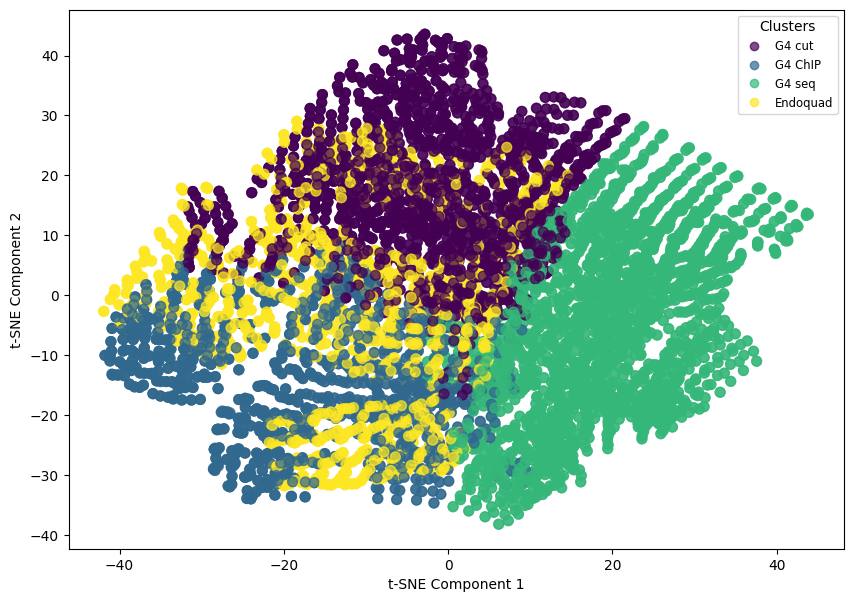

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, s=50, cmap='viridis', alpha=0.7)
# plt.title('')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
handles, _ = scatter.legend_elements()
cluster_names = ["G4 cut", "G4 ChIP", "G4 seq", "Endoquad"]  # Adjust cluster names as needed
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')
plt.show()

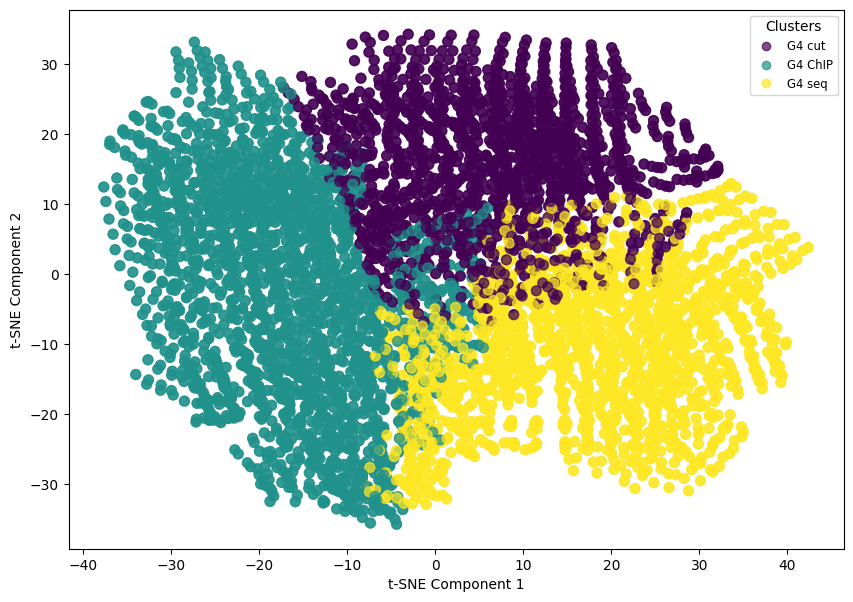

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, s=50, cmap='viridis', alpha=0.7)
# plt.title('')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
handles, _ = scatter.legend_elements()
cluster_names = ["G4 cut", "G4 ChIP", "G4 seq"]  # Adjust cluster names as needed
legend = plt.legend(handles, cluster_names, title="Clusters", loc="best", fontsize='small')
plt.show()

<ipython-input-20-53829c808d34>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, cmap='viridis', alpha=0.7)


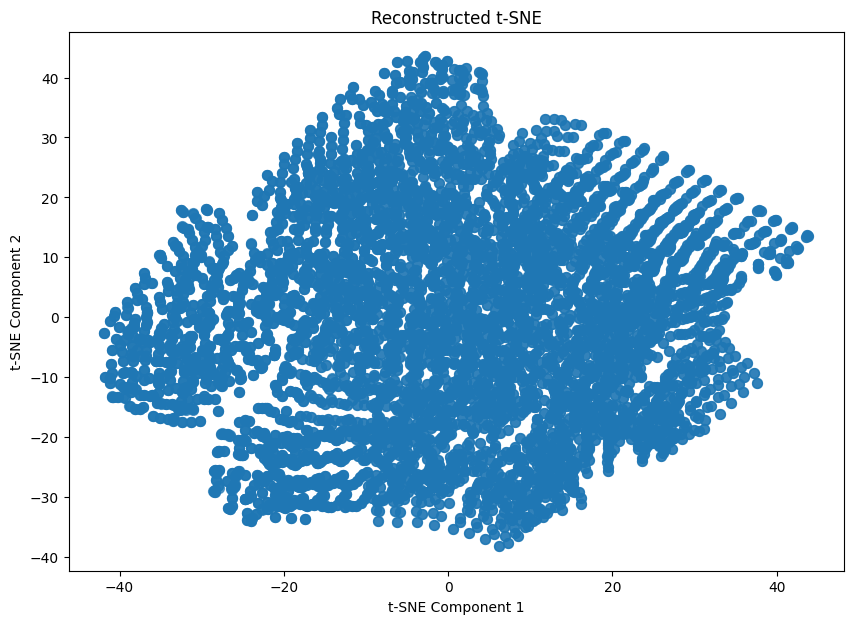

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, cmap='viridis', alpha=0.7)
plt.title('Reconstructed t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
plt.show()

<ipython-input-13-04ea0b53e48b>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 1], tsne_results[:, 2], s=50, cmap='viridis', alpha=0.7)


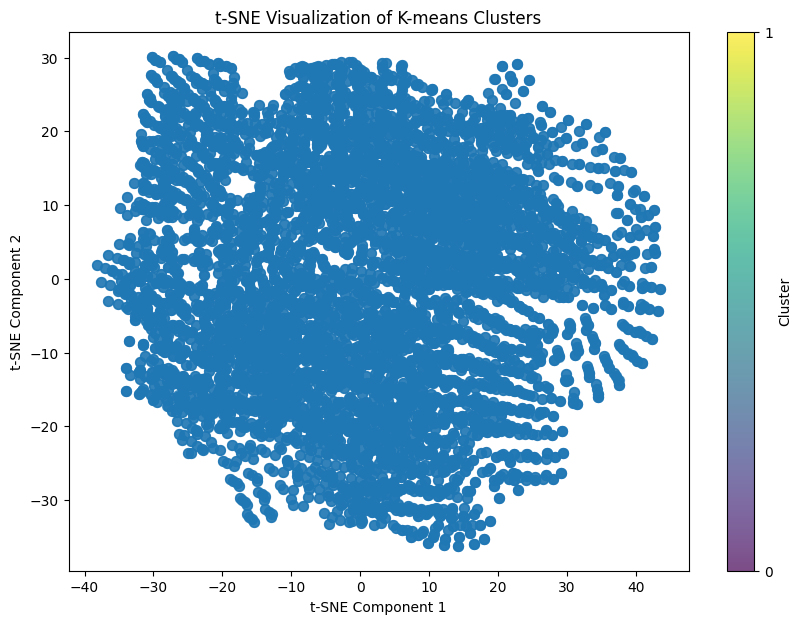

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 1], tsne_results[:, 2], s=50, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of K-means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
plt.show()

<ipython-input-49-7ef51cba0d7d>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, cmap='viridis', alpha=0.7)


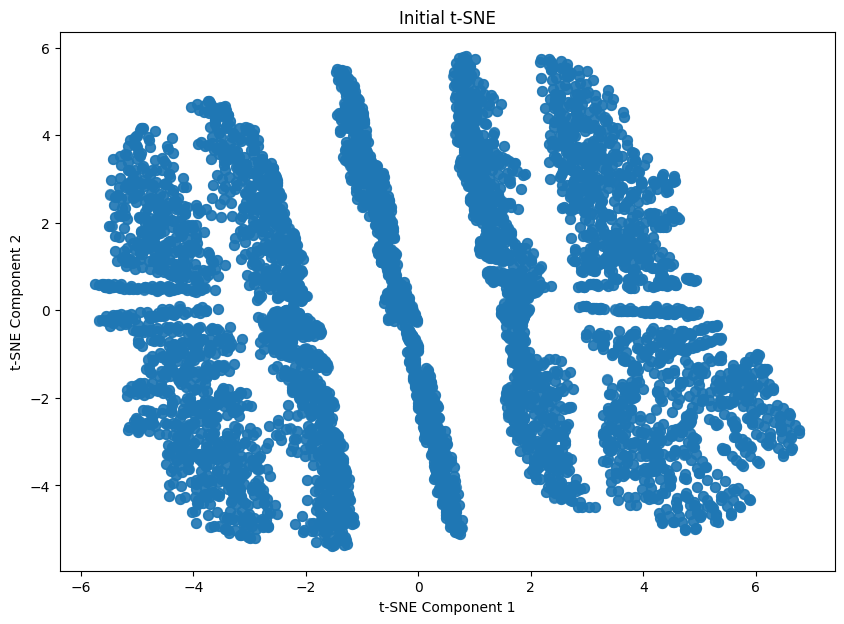

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, cmap='viridis', alpha=0.7)
plt.title('Initial t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

<ipython-input-50-3965f59056e1>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 2], s=50, cmap='viridis', alpha=0.7)


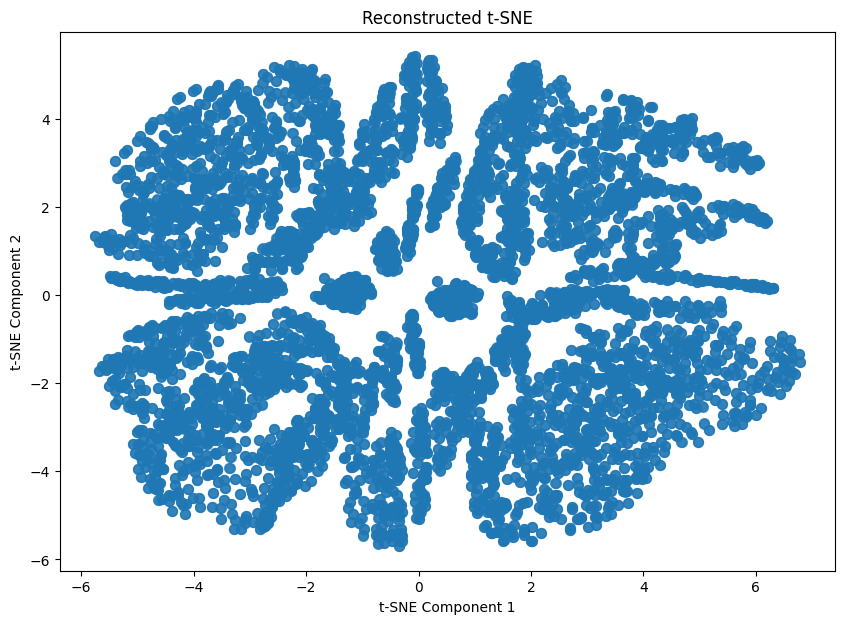

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 2], s=50, cmap='viridis', alpha=0.7)
plt.title('Initial t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.colorbar(scatter, ticks=range(2), label='Cluster')
plt.show()